# PHE SEIR Model

In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import gamma, nbinom, norm
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

### Define setup matrices for the PHE Model

In [2]:
# Populate the model
total_days =  132
regions = ['London']
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))
matrices_region = []

### Variable
# Initial state of the system
for w in weeks:
    weeks_matrices_region = []
    for r in regions:
        path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
        region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
        #region_data_matrix_var.iloc[:, 5] = region_data_matrix_var.iloc[:, 5] * 2
        regional = em.RegionMatrix(r, age_groups, region_data_matrix)
        weeks_matrices_region.append(regional)

    matrices_region.append(weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = np.arange(1, total_days+1, 7).tolist()

### Fixed
## Initial state of the system
#weeks_matrices_region = []
#for r in regions:
#    path = os.path.join('../../data/final_contact_matrices/BASE.csv')
#    region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
#    regional = em.RegionMatrix(r, age_groups, region_data_matrix)
#    #region_data_matrix_fix.iloc[:, 5] = region_data_matrix_fix.iloc[:, 5] * 2
#    weeks_matrices_region.append(regional)
#
#matrices_region.append(weeks_matrices_region)
#
#contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
#matrices_contact = [contacts]
#
## Matrices contact
#time_changes_contact = [1]
#time_changes_region = [1]

### Set the parameters and initial conditions of the model and bundle everything together to simulate

In [3]:
# Instantiate model
model = em.PheSEIRModel()

# Set the region names, contact and regional data of the model
model.set_regions(regions)
model.read_contact_data(matrices_contact, time_changes_contact)
model.read_regional_data(matrices_region, time_changes_region)

# Initial number of susceptibles
susceptibles = [
    #[68124, 299908, 773741, 668994, 1554740, 1632059, 660187, 578319],
    [117840, 488164, 1140597, 1033029, 3050671, 2050173, 586472, 495043],
    #[116401, 508081, 1321675, 1319046, 2689334, 2765974, 1106091, 943363],
    #[85845, 374034, 978659, 1005275, 2036049, 2128261, 857595, 707190],
    #[81258, 348379, 894662, 871907, 1864807, 1905072, 750263, 624848],
    #[95825, 424854, 1141632, 1044242, 2257437, 2424929, 946459, 844757],
    #[53565, 237359, 641486, 635602, 1304264, 1499291, 668999, 584130]
    ]

#infectives1 = (10 * np.ones((len(regions), len(age_groups)))).tolist()
#infectives1 = (1 * np.ones((len(regions), len(age_groups)))).tolist()
infectives1 = [
    #[0, 0, 0, 0, 0, 1, 0, 0],
    [10, 10, 50, 100, 150, 50, 50, 50],
    #[0, 0, 0, 0, 0, 0, 1, 0],
    #[0, 0, 0, 0, 1, 0, 0, 0],
    #[0, 0, 0, 0, 0, 1, 0, 0],
    #[0, 0, 0, 1, 0, 0, 0, 0],
    #[0, 0, 0, 0, 0, 1, 0, 0]
    ]
infectives2 = np.zeros((len(regions), len(age_groups))).tolist()

dI = 4
dL = 4

# Initial R number by region
#psis = gamma.rvs(31.36, scale=1/224, size=len(regions))
psis = (31.36/224)*np.ones(len(regions))
#initial_r = np.multiply(dI*psis, np.divide(np.square((dL/2)*psis+1), 1 - 1/np.square((dI/2)*psis+1)))

initial_r = 2.50837101*np.ones(len(regions))

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

## Read Death and Serology data

In [4]:
# Read in death and positive data from external files
deaths_data = []
positives_data = []
tests = []

for region in regions:
    deaths_data.append(np.loadtxt('../../data/death_data/{}_deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data.append(np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(region), dtype=int, delimiter=','))
    tests.append(np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=','))

In [5]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(27, total_days+1, 1).tolist()
serology_times = np.arange(80, total_days+1, 7).tolist()

In [25]:
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = (1/100 * np.array([0.0016, 0.0016, 0.0043, 0.019, 0.08975, 0.815, 3.1, 6.05])).tolist()
time_to_death.extend([0.0] * (len(times)-30))
niu = float(gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

In [7]:
betas= np.ones((len(regions), len(times)))

spec_betas = [0.78504677, 0.63896579, 0.54468104, 0.49333066,
       0.46377682, 0.4452276, 0.43778319, 0.43073676, 0.42822702,
       0.42669255, 0.42625656, 0.42754894, 0.42844581]

for r in range(len(regions)):
    for _, day in enumerate(np.arange(44, len(times), 7)):
        betas[r, day:(day+7)]=spec_betas[_]

In [8]:
betas

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.78504677,
        0.78504677, 0.78504677, 0.78504677, 0.78504677, 0.78504677,
        0.78504677, 0.63896579, 0.63896579, 0.63896579, 0.63896579,
        0.63896579, 0.63896579, 0.63896579, 0.54468104, 0.54468104,
        0.54468104, 0.54468104, 0.54468104, 0.54468104, 0.54468104,
        0.49333066, 0.49333066, 0.49333066, 0.49333066, 0.49333066,
        0.49333066, 0.49333066, 0.46377682, 0.46

In [9]:
# Simulate for all regions
predicted_new_infec = []
predicted_deaths = []
predicted_reprod_num = []

parameters = [
        initial_r, 0, susceptibles, np.zeros((len(regions), len(age_groups))).tolist(), np.zeros((len(regions), len(age_groups))).tolist(),
        infectives1, infectives2, np.zeros((len(regions), len(age_groups))).tolist(), betas.tolist(), dL, dI, 0.5]

m_fix = em.MultiTimesInfectivity(matrices_contact, time_changes_contact, regions, matrices_region,
                                 time_changes_region, parameters[0], parameters[10], parameters[2])

for r, reg in enumerate(regions):
    r_fix = np.empty(len(times))
    model_reg_deaths_data = np.empty(len(times))

    # List of common initial conditions and parameters that characterise the fixed and variable model
    parameters[1] = r+1
    
    # Simulate using the ODE solver from scipy
    scipy_method = 'RK45'
    parameters.append(scipy_method)

    model_output = model.simulate(list(deepflatten(parameters, ignore=str)), times)

    age_model_reg_new_infections = model.new_infections(model_output)
    model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

    for t, time in enumerate(times):
        r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)])
        model_reg_deaths_data[t] = np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))

    predicted_new_infec.append(model_reg_new_infections)
    predicted_deaths.append(model_reg_deaths_data)
    predicted_reprod_num.append(r_fix)

<ipython-input-9-650f19645f54>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)])


### Plot data vs predicted

In [10]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
outputs = [deaths_data, positives_data]

# Number of regions
n_reg = len(regions)

In [11]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (bar chart cases each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=predicted_new_infec[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=serology_times,
            y=np.sum(np.multiply(np.nan_to_num(np.divide(positives_data[r], tests[r])), susceptibles[r]), axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=predicted_deaths[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=predicted_reprod_num[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, 132, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, 132, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, 132, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-2.pdf')
fig.show()

<ipython-input-11-820fd4131b39>:26: RuntimeWarning:

invalid value encountered in true_divide



### Compute the log-likelihood for the choice of parameters

In [12]:
# Initialise log-likelihood
loglikelihood = em.PHELogLik(
            model, times,
            deaths_data, time_to_death, deaths_times,
            fatality_ratio,
            tests, positives_data, serology_times, sens, spec,
            wd=1, wp=0)

# Select the ICs for the fixed parameters
loglikelihood._parameters[2:7] = parameters[2:7]

# Compute the log-likelihood
eval_ll = list(deepflatten([initial_r, betas], ignore=str))
print(loglikelihood(eval_ll))

-9762.466951472512


### Optimisation

In [54]:
## Initialise optimisation for the model
phe_inference = em.PheSEIRInfer(model)

# Add death and tests data to the optimisation structure
phe_inference.read_deaths_data(deaths_data, deaths_times, time_to_death, fatality_ratio)
phe_inference.read_serology_data(tests, positives_data, serology_times, sens, spec)

# Run optimisation structure
found = phe_inference.optimisation_problem_setup(times, wd=1, wp=0)
found

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 11
Iter. Eval.  Best      Time m:s
0     11     -12913.09   0:00.9
1     22     -12913.09   0:01.9
2     33     -12655.87   0:02.7
3     44     -11779.61   0:03.6
20    231    -6513.065   0:18.6
40    451    -4948.6     0:35.9
60    671    -4584.188   0:53.2
80    891    -4159.932   1:10.3
100   1111   -3929.755   1:27.3
120   1331   -3783.695   1:44.1
140   1551   -3729.285   2:00.8
160   1771   -3716.724   2:17.6
180   1991   -3714.86    2:34.1
200   2211   -3714.341   2:50.8
220   2431   -3714.279   3:07.4
240   2651   -3714.203   3:23.8
256   2816   -3714.189   3:36.1
Halting: No significant change for 100 iterations.
[2.99753253 0.77098157 0.63026172 0.55399237 0.51290934 0.49503688
 0.48587864 0.48248407 0.48054474 0.47979022 0.47935997 0.47953734
 0.47962706 0.47996558] -3714.189096766625
Optimisation phase is finished.


array([2.99753253, 0.77098157, 0.63026172, 0.55399237, 0.51290934,
       0.49503688, 0.48587864, 0.48248407, 0.48054474, 0.47979022,
       0.47935997, 0.47953734, 0.47962706, 0.47996558])

### Inference

In [14]:
## Initialise inference for the model
phe_inference = em.PheSEIRInfer(model)

# Add death and tests data to the inference structure
phe_inference.read_deaths_data(deaths_data, deaths_times, time_to_death, fatality_ratio)
phe_inference.read_serology_data(tests, positives_data, serology_times, sens, spec)

# Run inference structure
samples = phe_inference.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 11
Iter. Eval.  Best      Time m:s
0     11     -9834.976   0:01.0
1     22     -9834.976   0:01.9
2     33     -9834.976   0:02.8
3     44     -9834.976   0:03.7
20    231    -7721.139   0:19.3
40    451    -5033.86    0:36.7
60    671    -4489.314   0:54.1
80    891    -4197.901   1:11.1
100   1111   -3957.14    1:28.2
120   1331   -3795.523   1:45.2
140   1551   -3724.051   2:02.0
160   1771   -3714.154   2:18.8
180   1991   -3712.885   2:35.4
200   2211   -3712.049   2:52.1
220   2431   -3711.857   3:08.6
240   2651   -3711.787   3:25.2
254   2794   -3711.773   3:36.0
Halting: No significant change for 100 iterations.
[2.98462392 0.78068645 0.63767353 0.55789073 0.51622963 0.49512814
 0.48507868 0.48158463 0.47953811 0.47909818 0.47874182 0.47877224
 0.47875432 0.47867653] -3711.7725177942993
Optimisation phase is finished.
Running...
Using Haario-Bardenet a

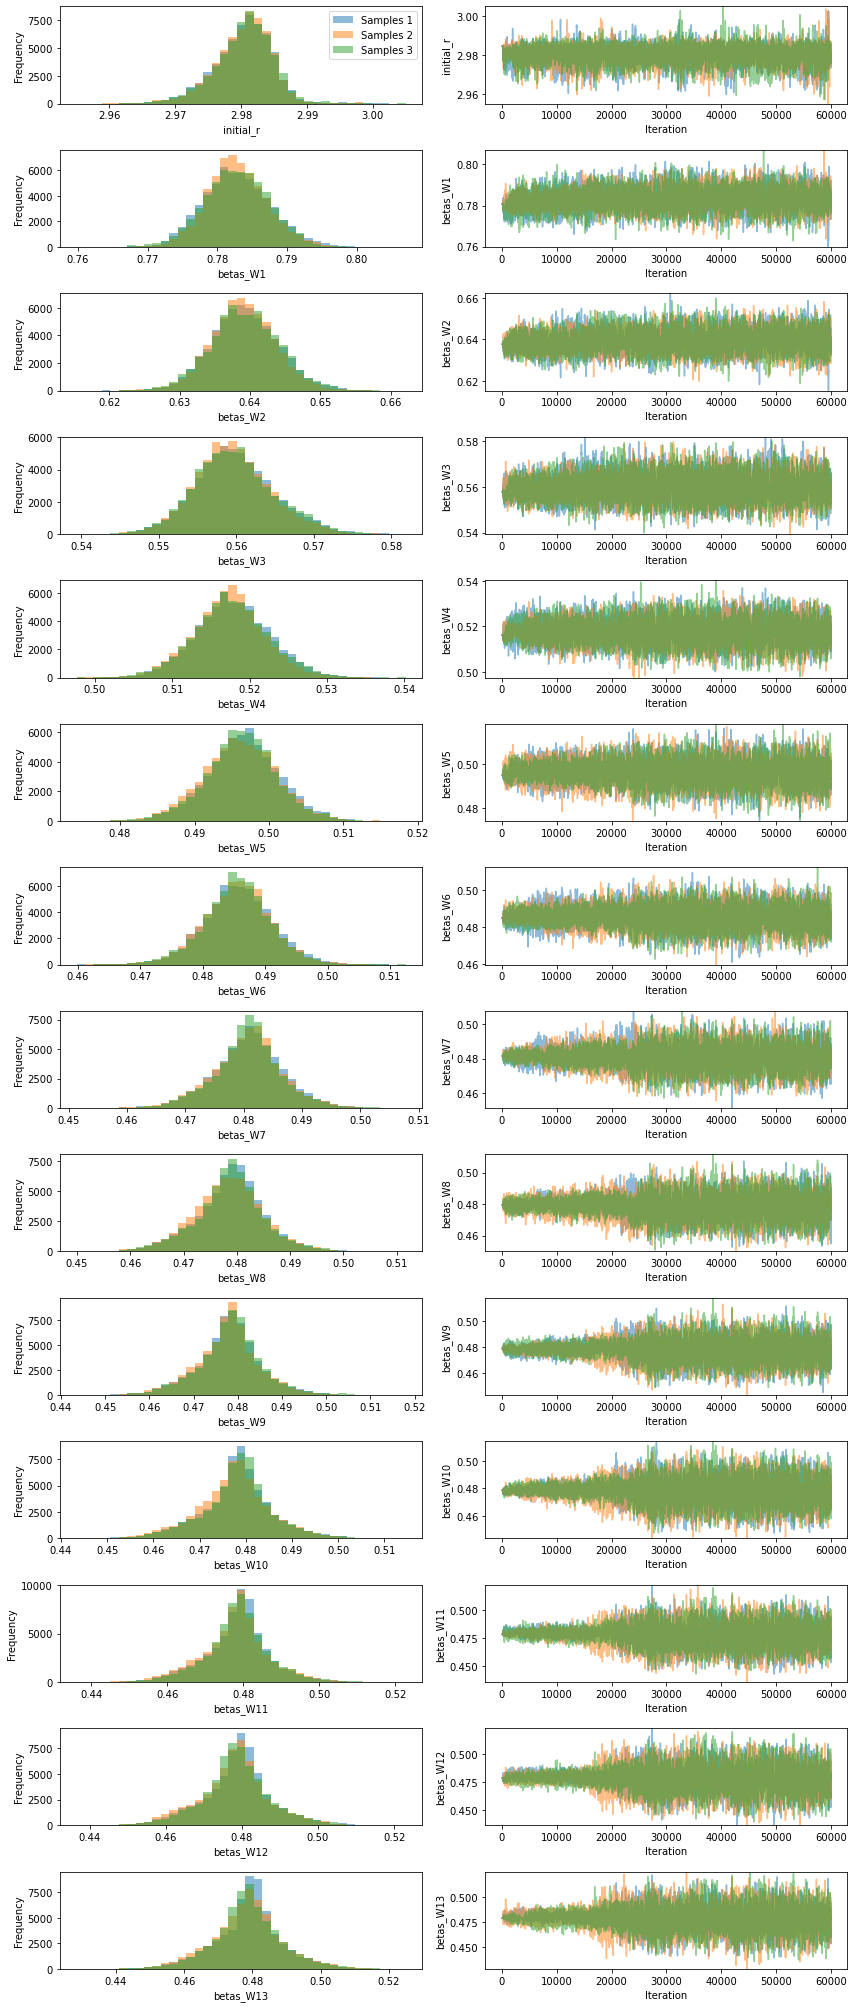

In [18]:
import pints.plot

param_names = ['initial_r']
param_names.extend(['betas_W{}'.format(i+1) for i in range(len(np.arange(44, len(times), 7)))])

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

In [19]:
samples = samples[:, 30000:, :]

pints.rhat(samples)

array([1.00196752, 1.0008866 , 1.0045461 , 1.0028206 , 1.00206605,
       1.00354748, 1.00126181, 1.0018615 , 1.00140141, 1.00184911,
       1.00171433, 1.00207934, 1.00187996, 1.00159747])

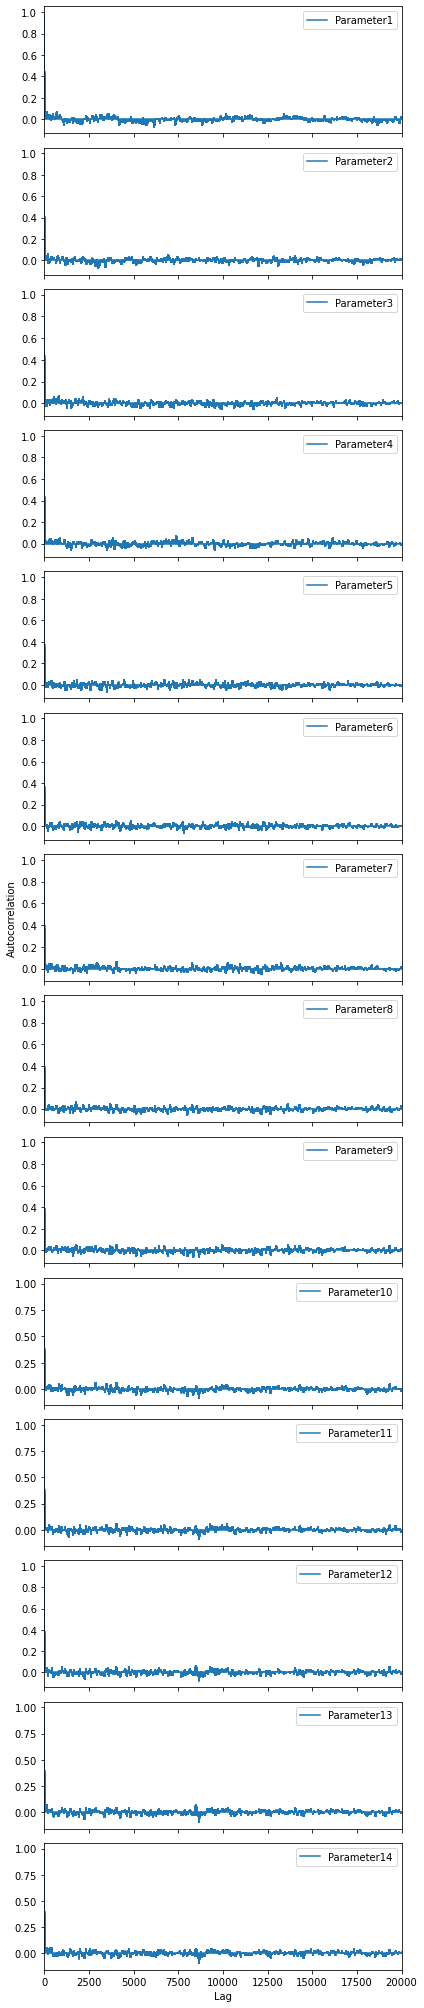

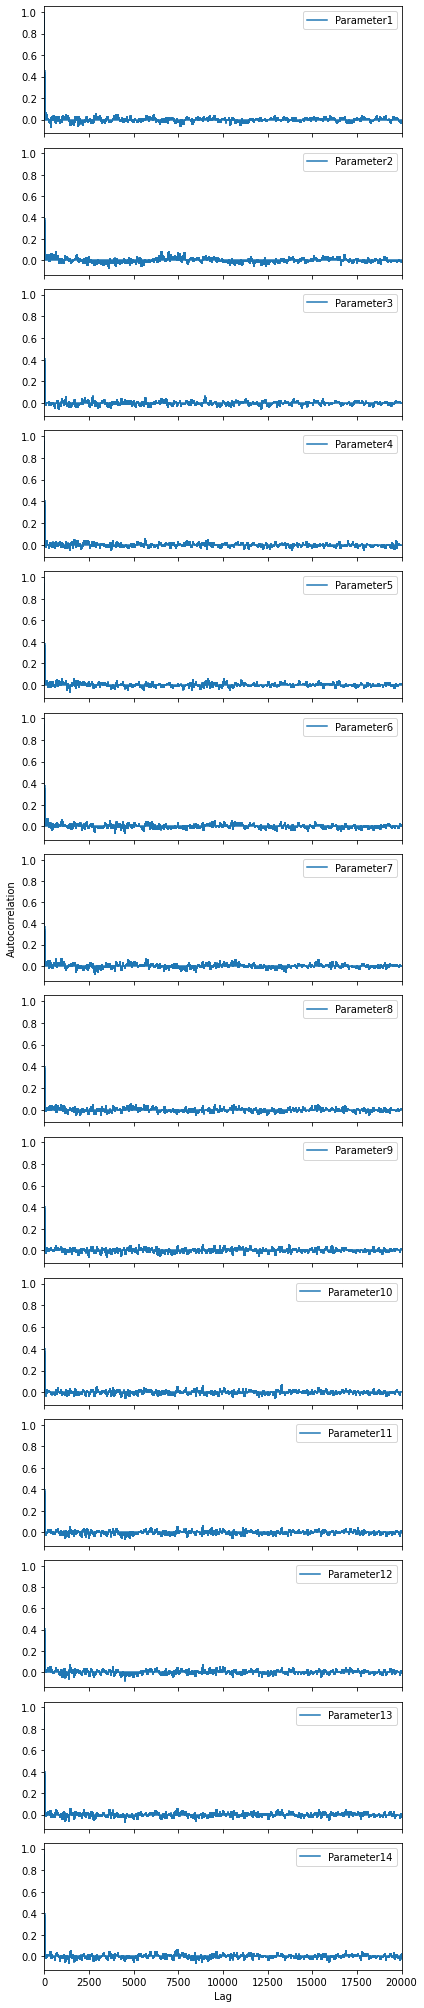

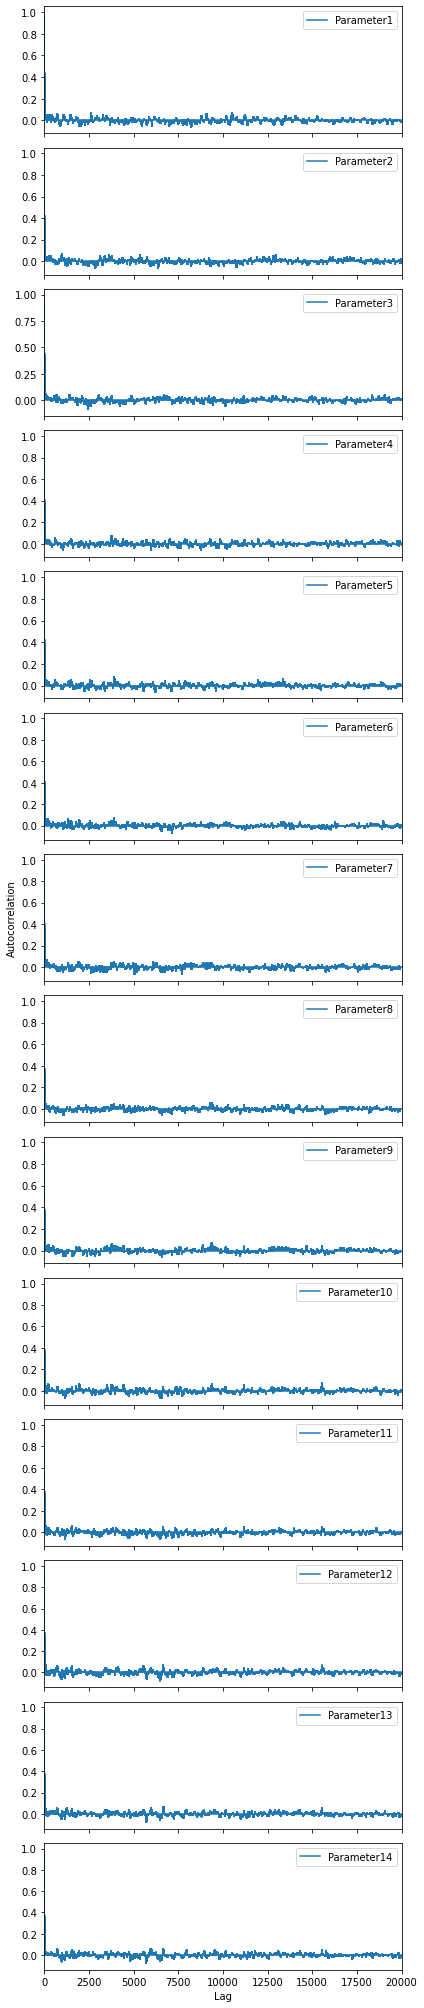

In [20]:
for sample in samples:
    pints.plot.autocorrelation(sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run model for the sampled parameter choices to compute the expected number of deaths, new infections and the reproduction number

In [42]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

n_parameters = model.n_parameters()

predicted_new_infec = []
predicted_deaths = []
predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(model.regions):
    reg_predicted_new_infec = []
    reg_predicted_deaths = []
    reg_predicted_reprod_num = []

    parameters[1] = r+1

    for params in extended_samples[::thinning, :]:
        parameters[0] = [params[0]] * len(model.regions)
        LEN = len(np.arange(44, len(times), 7))

        betas = np.array(parameters[8])
        for r in range(len(model.regions)):
            for d, day in enumerate(np.arange(44, len(times), 7)):
                betas[r, day:(day+7)] = params[r*LEN+d+1]

        parameters[8] = betas.tolist()
        
        r_fix = np.empty(len(times))
        model_reg_deaths_data = np.empty(len(times))

        m_fix = em.MultiTimesInfectivity(
            matrices_contact, time_changes_contact, regions, matrices_region, time_changes_region, parameters[0], dI, susceptibles)

        # Run model and number of new infections for all age groups
        model_output = model.simulate(
            parameters=list(deepflatten(parameters, ignore=str)),
            times=times
        )
        age_model_reg_new_infections = model.new_infections(model_output)
        model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

        for t, time in enumerate(times):
            r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)])
            model_reg_deaths_data[t] = np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))

        reg_predicted_new_infec.append(model_reg_new_infections)
        reg_predicted_deaths.append(model_reg_deaths_data)
        reg_predicted_reprod_num.append(r_fix)

    reg_predicted_new_infec = np.array(reg_predicted_new_infec)

    predicted_new_infec.append(reg_predicted_new_infec)
    predicted_deaths.append(reg_predicted_deaths)
    predicted_reprod_num.append(reg_predicted_reprod_num)

predicted_new_infec = np.array(predicted_new_infec)
predicted_deaths = np.array(predicted_deaths)
predicted_reprod_num = np.array(predicted_reprod_num)


<ipython-input-42-03580fc15676>:48: ComplexWarning:

Casting complex values to real discards the imaginary part



### Plot the mean and CI bounds of the trajectories of interest

In [43]:
# Set up traces to plot
new_infec_mean = []
deaths_mean = []
reprod_num_mean = []

new_infec_upper = []
deaths_upper = []
reprod_num_upper = []

new_infec_lower = []
deaths_lower = []
reprod_num_lower = []

for r, _ in enumerate(model.regions):
    # Compute the mean 
    new_infec_mean.append(np.mean(predicted_new_infec[r,:,:], axis=0))
    deaths_mean.append(np.mean(predicted_deaths[r,:,:], axis=0))
    reprod_num_mean.append(np.mean(predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    new_infec_upper.append(np.quantile(predicted_new_infec[r,:,:], 0.975, axis=0))
    deaths_upper.append(np.quantile(predicted_deaths[r,:,:], 0.975, axis=0))
    reprod_num_upper.append(np.quantile(predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    new_infec_lower.append(np.quantile(predicted_new_infec[r,:,:], 0.025, axis=0))
    deaths_lower.append(np.quantile(predicted_deaths[r,:,:], 0.025, axis=0))
    reprod_num_lower.append(np.quantile(predicted_reprod_num[r,:,:], 0.025, axis=0))

In [44]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (bar chart cases each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=new_infec_upper[r].tolist() + new_infec_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=serology_times,
            y=np.sum(np.multiply(np.nan_to_num(np.divide(positives_data[r], tests[r])), susceptibles[r]), axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=deaths_upper[r].tolist() + deaths_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=reprod_num_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=reprod_num_upper[r].tolist() + reprod_num_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, 93, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29', 'May 09', 'May 19', 'May 29']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, 93, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29', 'May 09', 'May 19', 'May 29']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, 93, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29', 'May 09', 'May 19', 'May 29']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-2.pdf')
fig.show()

<ipython-input-44-0e6028dd587e>:42: RuntimeWarning:

invalid value encountered in true_divide

